# Exercise 4  -  Clustering with scikit-learn

Guadagnini Michele - 1230663

Lambertini Alessandro - 1242885

Pagano Alice - 1236916

Puppin Michele - 1227474

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True) 

In [2]:
df = pd.read_table("data_t-SNE_310101_d5_R100_e1_N800.dat", sep="\t", header=None)
#df = pd.read_table("data_t-SNE_310101_d5_R50_e3_N1000_more-noisy.dat", sep="\t", header=None)


print('Shape of the dataframe:', df.shape)

N = df.shape[0]

Shape of the dataframe: (800, 5)


In [3]:
#df.head()
df.describe()

,0,1,2,3,4
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-16476.360000,28546.316250,25527.812500,-16218.585000,-16114.060000
std,54967.337335,57227.087906,53304.052987,56260.179488,30616.588757
min,-122590.000000,-92990.000000,-82105.000000,-117860.000000,-74020.000000
25%,-64056.750000,-20505.250000,-13408.500000,-65008.250000,-37753.000000
50%,-15598.000000,41994.000000,35943.500000,-20322.000000,-14077.000000
75%,28181.750000,76316.000000,68741.500000,37434.750000,3358.250000
max,83813.000000,103995.000000,105292.000000,95840.000000,38848.000000



## A - Introduction of dataset and 3D visualization

In [4]:
N_red = int(0.1*N)
N_green = int(0.3*N)
N_blue = int(0.6*N)

red_df = df[:N_red]
green_df = df[N_red:N_red+N_green]
blue_df = df[N_red+N_green:N]

print('Shape of the red dataset:', red_df.shape)
print('Shape of the green dataset:', green_df.shape)
print('Shape of the blue dataset:', blue_df.shape)

ytrue = [0]*N_red + [1]*N_green + [2]*N_blue

Shape of the red dataset: (80, 5)
Shape of the green dataset: (240, 5)
Shape of the blue dataset: (480, 5)


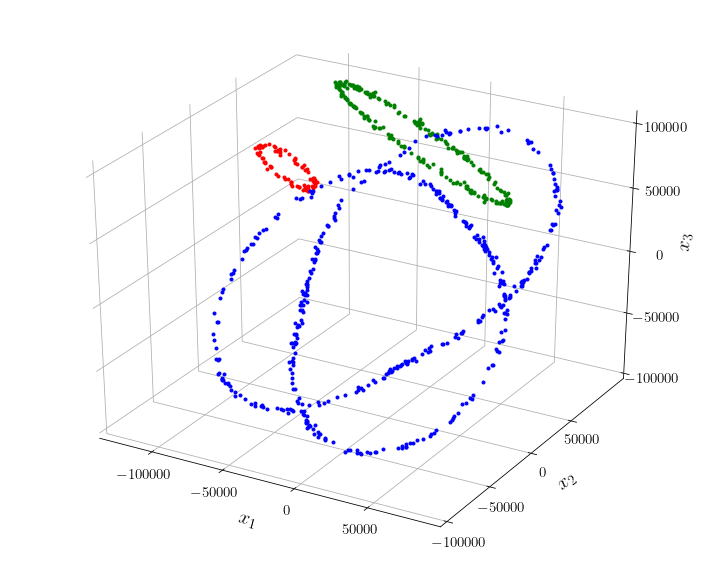

In [5]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(red_df[0],red_df[1],red_df[2],'.',color='red')
ax.plot(green_df[0],green_df[1],green_df[2],'.',color='green')
ax.plot(blue_df[0],blue_df[1],blue_df[2],'.',color='blue')

#ax.set_title('3d plot of first 3 dimensions')
ax.set_xlabel('$x_1$',fontsize=20,labelpad=10)
ax.set_ylabel('$x_2$',fontsize=20,labelpad=10)
ax.set_zlabel('$x_3$',fontsize=20,labelpad=15)

ax.set_xticks([-100000,-50000,0,50000])
ax.set_yticks([-100000,-50000,0,50000])
ax.set_zticks([-100000,-50000,0,50000,100000])

ax.tick_params(labelsize=15)
ax.tick_params(axis='z', which='major',labelsize=15, pad=11)
ax.grid(linewidth=2)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.tight_layout(h_pad=0.1)
    
plt.savefig('3drep.eps', format='eps')

## B - DBSCAN on 5D

In [6]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

In [7]:
from sklearn.manifold import TSNE
import numpy as np

In [8]:
np.random.seed(12345)

X = StandardScaler().fit_transform(df)

#X_emb_5 = TSNE(n_components=2, perplexity=5.0).fit_transform(df)
X_emb_30 = TSNE(n_components=2, perplexity=26.0).fit_transform(X)
#X_emb_50 = TSNE(n_components=2, perplexity=50.0).fit_transform(df)
#X_emb_100 = TSNE(n_components=2, perplexity=100.0).fit_transform(df)

In [9]:
def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)


cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

In [10]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens


In [11]:
a = int(np.log(800) +.5)
print(a)

7


In [12]:
def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(np.sqrt( (X[i,0]-X[j,0])**2 + (X[i,1]-X[j,1])**2 
                                + (X[i,2]-X[j,2])**2 + (X[i,3]-X[j,3])**2 + (X[i,4]-X[j,4])**2 )) 

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

eps_dist = calculate_kn_distance(X,6)

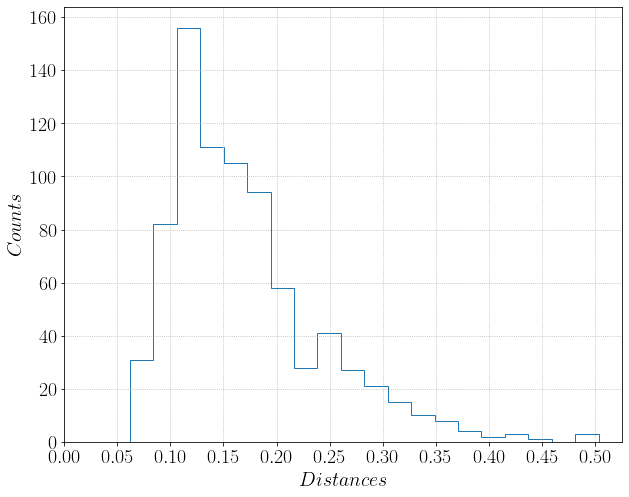

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(eps_dist,bins=20,histtype="step")
ax.grid(linestyle='dotted')
ax.set_ylabel('$Counts$', fontsize=20)
ax.set_xlabel('$Distances$', fontsize=20)
ax.tick_params(labelsize=20)
plt.xticks(np.arange(0, max(eps_dist),0.05 )) 

plt.savefig('kdist.eps', format='eps') 

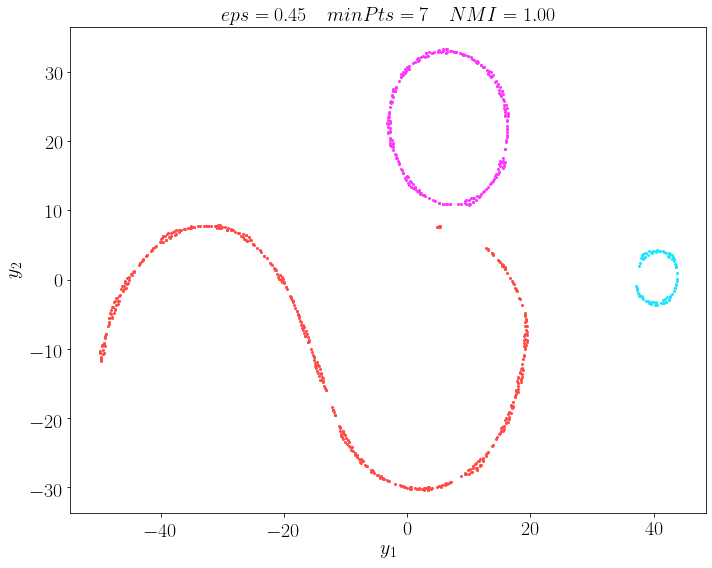

In [14]:
eps = 0.45

min_samples = 7

fig, ax = plt.subplots(figsize=(10,8))

model = DBSCAN(eps=eps, min_samples=min_samples)
model.fit(X)
y = model.labels_
plotting_ax(X_emb_30,y,ax)
nmi=NMI(ytrue, y)
ax.set_title('$eps=%.2f \quad minPts=%i \quad NMI=%.2f$'%(eps,min_samples,nmi), fontsize=20)
ax.set_xlabel('$y_1$', fontsize=20)
ax.set_ylabel('$y_2$', fontsize=20)
ax.tick_params(labelsize=20)
plt.tight_layout(h_pad=0.5)

plt.savefig('dbscan5dim.eps', format='eps') 

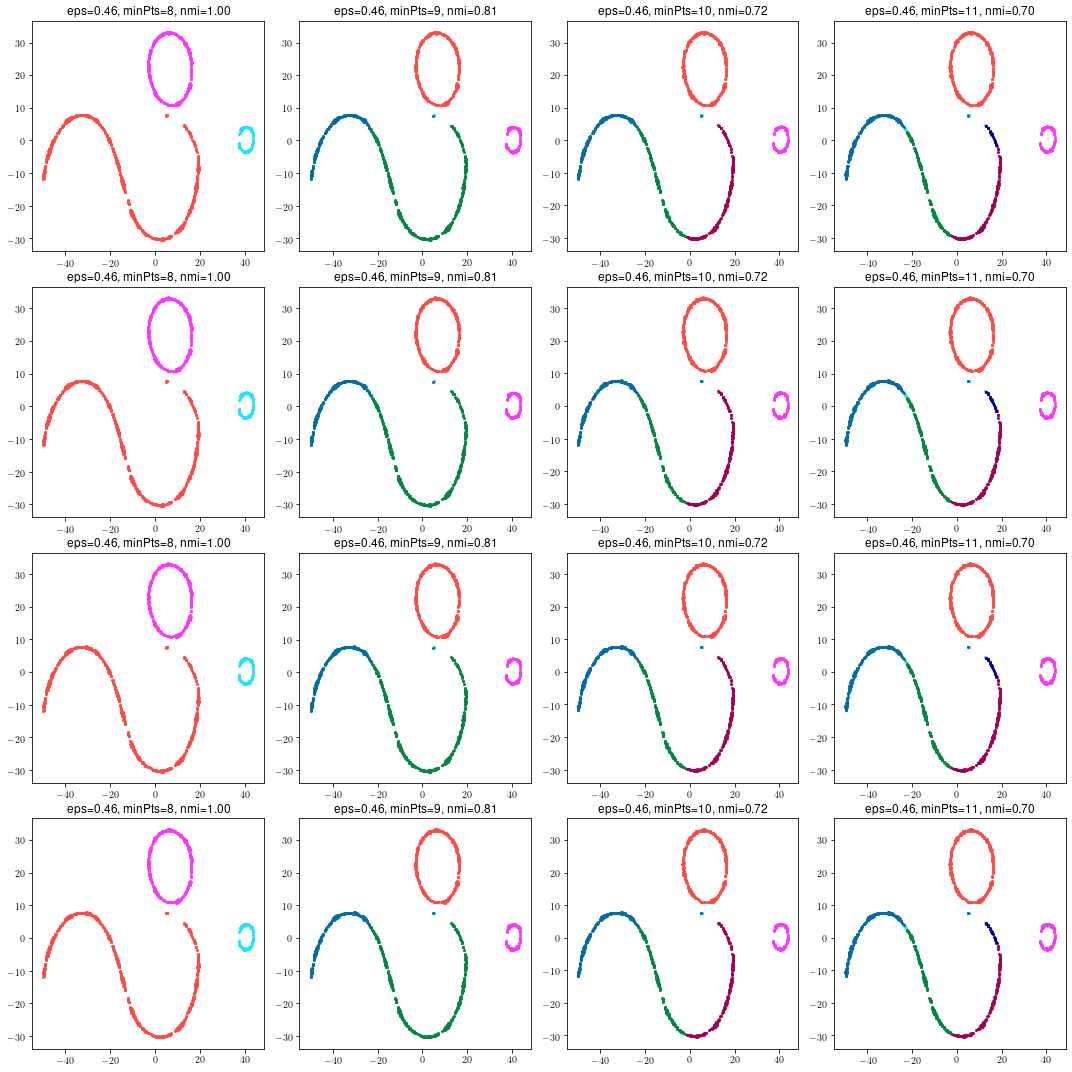

In [29]:
# The epsilon range is chosen as multiple of the minimum distance between points
#eps_range = [0.38,0.4,0.42,0.44]
#eps_range = [0.48,0.50,0.52,0.54]
eps_range = [0.46,0.46,0.46,0.46]

min_sample_range = [8,9,10,11]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,15))

for i, eps in enumerate(eps_range):    
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X_emb_30,y,ax[i,j])
        nmi=NMI(ytrue, y)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
        
plt.tight_layout(h_pad=0.5)
plt.show()

## C - t-SNE algorithm

In [16]:
from sklearn.manifold import TSNE
import numpy as np

In [17]:
dfsc = StandardScaler().fit_transform(df)
for i in range(5):
    print(dfsc[i].mean(), dfsc[i].std(), dfsc[i].max(), dfsc[i].min())

-0.4615059916012652 0.8351535154691663 0.8125886298454962 -1.4961566242984237
-0.6966000545363039 1.027697824722843 0.8070321072732162 -1.770696391047122
-0.5043546196784859 0.8897564183356846 0.8193277906679574 -1.6150183281842458
-0.6086609181123487 0.9722109537746789 0.8644933086034495 -1.7333108902887802
-0.43355702915303934 0.7698315018829127 0.7262560375822673 -1.4145914927676169


In [18]:
np.random.seed(12345)
X_emb_5 = TSNE(n_components=2, perplexity=5.0).fit_transform(dfsc)

np.random.seed(12345)
X_emb_30 = TSNE(n_components=2, perplexity=26.0).fit_transform(dfsc)
#X_emb_50 = TSNE(n_components=2, perplexity=50.0).fit_transform(df)
#X_emb_100 = TSNE(n_components=2, perplexity=100.0).fit_transform(df)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

ax1.plot(X_emb_5[:,0],X_emb_5[:,1],'.',color='red')
ax1.set_title('$Perplexity = 5.0$', fontsize=20)
ax1.tick_params(labelsize=20)
ax1.set_xlabel('$y_1$', fontsize=20)
ax1.set_ylabel('$y_2$', fontsize=20)
plt.tight_layout(h_pad=0.5)

plt.savefig('perp1.eps', format='eps') 

In [ ]:
fig = plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(111)
ax2.plot(X_emb_30[:,0],X_emb_30[:,1],'.',color='red')
ax2.set_title('$Perplexity = 26.0$', fontsize=20)
ax2.tick_params(labelsize=20)
ax2.set_xlabel('$y_1$', fontsize=20)
ax2.set_ylabel('$y_2$', fontsize=20)
plt.tight_layout(h_pad=0.5)
plt.savefig('perp2.eps', format='eps') 

## D - DBSCAN in projected data with t-SNE 

In [ ]:
X = StandardScaler().fit_transform(X_emb_5)

def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(np.sqrt( (X[i,0]-X[j,0])**2 + (X[i,1]-X[j,1])**2 )) 

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

eps_dist = calculate_kn_distance(X,6)

fig, ax = plt.subplots(figsize=(10,8))
ax.hist(eps_dist,bins=20,histtype="step")
ax.grid(linestyle='dotted')
ax.set_ylabel('$Counts$', fontsize=20)
ax.set_xlabel('$Distances$', fontsize=20)
ax.tick_params(labelsize=20)
plt.xticks(np.arange(0, max(eps_dist), max(eps_dist)/10 )) 

plt.show()

In [ ]:
eps = 0.18

min_samples = 7

fig, ax = plt.subplots(figsize=(10,8))

#X = X_emb_5
model = DBSCAN(eps=eps, min_samples=min_samples)
model.fit(X)
y = model.labels_
plotting_ax(X_emb_5,y,ax)
nmi=NMI(ytrue, y)
ax.set_title('$eps=%.2f \quad minPts=%i \quad NMI=%.2f$'%(eps,min_samples,nmi), fontsize=20)
ax.set_xlabel('$y_1$', fontsize=20)
ax.set_ylabel('$y_2$', fontsize=20)
ax.tick_params(labelsize=20)
plt.tight_layout(h_pad=0.5)

#plt.savefig('dbscan2dim.eps', format='eps') 

In [ ]:
X = StandardScaler().fit_transform(X_emb_30)

def calculate_kn_distance(X,k):

    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(np.sqrt( (X[i,0]-X[j,0])**2 + (X[i,1]-X[j,1])**2 )) 

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

eps_dist = calculate_kn_distance(X,6)

fig, ax = plt.subplots(figsize=(10,8))
ax.hist(eps_dist,bins=20,histtype="step")
ax.grid(linestyle='dotted')
ax.set_ylabel('$Counts$', fontsize=20)
ax.set_xlabel('$Distances$', fontsize=20)
ax.tick_params(labelsize=20)
plt.xticks(np.arange(0, max(eps_dist), max(eps_dist)/10 )) 

plt.show()

In [ ]:
eps = 0.15

min_samples = 7

fig, ax = plt.subplots(figsize=(10,8))


#X = X_emb_30
model = DBSCAN(eps=eps, min_samples=min_samples)
model.fit(X)
y = model.labels_
plotting_ax(X_emb_30,y,ax)
nmi=NMI(ytrue, y)
ax.set_title('$eps=%.2f \quad minPts=%i \quad NMI=%.2f$'%(eps,min_samples,nmi), fontsize=20)
ax.set_xlabel('$y_1$', fontsize=20)
ax.set_ylabel('$y_2$', fontsize=20)
ax.tick_params(labelsize=20)
plt.tight_layout(h_pad=0.5)

print(y)
plt.savefig('dbscan2dim.eps', format='eps') 

In [ ]:
print(X_emb_30)
print(X)